# Are FiveThirtyEight's ELO Game Predictions Uniformly Accurate?

##### Taking FiveThirtyEight's ELO baseball game records from 1871-present and analyzing their accuracy based on team, regular season vs playoffs and "eras" of baseball.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import progressbar

Oddly, the format of the `date` feature changes at the century mark of 1900 (come on guys, that's the _last_ year of the century, not the first). I will divide the data by date format, convert to datetimes, then concatenate the dataframes. 

In [4]:
df = pd.read_csv('mlb_elo.csv')
df.tail()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
219969,1871-05-09,1871,0,NaN,TRO,ATL,1450.0,1451.483,0.532359,0.467641,...,NaN,NaN,NaN,NaN,0.522460,0.477540,1448.525,1452.958,5.0,9.0
219970,1871-05-08,1871,0,NaN,CHC,CL1,1450.0,1451.943,0.531700,0.468300,...,NaN,NaN,NaN,NaN,0.528402,0.471598,1451.256,1450.687,14.0,12.0
219971,1871-05-06,1871,0,NaN,RC1,CL1,1450.0,1448.754,0.536268,0.463732,...,NaN,NaN,NaN,NaN,0.532974,0.467026,1446.810,1451.943,4.0,12.0
219972,1871-05-05,1871,0,NaN,WS3,ATL,1450.0,1450.000,0.534484,0.465516,...,NaN,NaN,NaN,NaN,0.534484,0.465516,1448.517,1451.483,18.0,20.0
219973,1871-05-04,1871,0,NaN,FW1,CL1,1450.0,1450.000,0.534484,0.465516,...,NaN,NaN,NaN,NaN,0.534484,0.465516,1451.246,1448.754,2.0,0.0


In [5]:
df.columns

Index(['date', 'season', 'neutral', 'playoff', 'team1', 'team2', 'elo1_pre',
       'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post',
       'rating1_pre', 'rating2_pre', 'pitcher1', 'pitcher2', 'pitcher1_rgs',
       'pitcher2_rgs', 'pitcher1_adj', 'pitcher2_adj', 'rating_prob1',
       'rating_prob2', 'rating1_post', 'rating2_post', 'score1', 'score2'],
      dtype='object')

In [6]:
df.drop(columns=['neutral', 'elo1_pre','elo2_pre', 'elo_prob1', 'elo_prob2', \
                 'elo1_post', 'elo2_post', 'rating1_pre', 'rating2_pre', \
                 'pitcher1', 'pitcher2', 'pitcher1_rgs','pitcher2_rgs', 'pitcher1_adj', \
                 'pitcher2_adj','rating1_post', 'rating2_post'], inplace=True)

In [7]:
def determine_winner(row):
    if row['score1'] > row['score2']:
        return row['team1']
    else:
        return row['team2']
    
def determine_loser(row):
    if row['score1'] > row['score2']:
        return row['team2']
    else:
        return row['team1']
    
def guess_winner(row):
    if row['rating_prob1'] > 0.5:
        return row['team1']
    else:
        return row['team2']

def guess_loser(row):
    if row['rating_prob1'] > 0.5:
        return row['team2']
    else:
        return row['team1']
    
def determine_correctness(predicted_winner, winner):
    if predicted_winner == winner:
        return 1
    else:
        return 0

Because the FiveThirtyEight dataset contains dates of two different formats for the century, and also because MLB was less structured before 1900 (not to mention the fact that many teams sprung up only to disappear less than 100 games later), we'll take games played after 1900.

All franchises that have fielded teams during the 1900s have survived to this day.

In [8]:
# Get rid of pre-1900s games.
df = df.loc[:200673]

# Re-format the date (make sortable)
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

# Exclude games that have yet to happen (our set now covers 1900 through 2018)
df = df.loc[df['date'] < dt.datetime(2019, 1, 1)]
df.reset_index(inplace=True)

df['winner'] = df.apply(determine_winner, axis=1)
df['predicted_winner'] = df.apply(guess_winner, axis=1)
df['loser'] = df.apply(determine_loser, axis=1)
df['predicted_loser'] = df.apply(guess_loser, axis=1)
df['prediction_correct'] = df.apply(lambda x: determine_correctness(x['predicted_winner'], x['winner']), axis=1)
df['winner_pct'] = df.apply(lambda x: x['rating_prob1'] if (x['team1'] == x['winner']) else x['rating_prob2'], axis=1)
df['loser_pct'] = df.apply(lambda x: x['rating_prob2'] if (x['team1'] == x['winner']) else x['rating_prob1'], axis=1)
df.head()

,index,date,season,playoff,team1,team2,rating_prob1,rating_prob2,score1,score2,winner,predicted_winner,loser,predicted_loser,prediction_correct,winner_pct,loser_pct
0,2430,2018-10-28,2018,w,LAD,BOS,0.483877,0.516123,1.0,5.0,BOS,BOS,LAD,LAD,1,0.516123,0.483877
1,2431,2018-10-27,2018,w,LAD,BOS,0.508342,0.491658,6.0,9.0,BOS,LAD,LAD,BOS,0,0.491658,0.508342
2,2432,2018-10-26,2018,w,LAD,BOS,0.555907,0.444093,3.0,2.0,LAD,LAD,BOS,BOS,1,0.555907,0.444093
3,2433,2018-10-24,2018,w,BOS,LAD,0.619808,0.380192,4.0,2.0,BOS,BOS,LAD,LAD,1,0.619808,0.380192
4,2434,2018-10-23,2018,w,BOS,LAD,0.648954,0.351046,8.0,4.0,BOS,BOS,LAD,LAD,1,0.648954,0.351046


In [9]:
# # Get rid of pre-1900s games.
# df = df.loc[:200673]

# # Re-format the date (make sortable)
# df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

# # Exclude games that have yet to happen (our set now covers 1900 through 2018)
# df = df.loc[df['date'] < dt.datetime(2019, 1, 1)]
# df.reset_index(inplace=True)

# # Add fields to the data. Includes stating the predicted winning team, winning team, and prediction correctness
# # for each game.
# predictedws = []
# predictedls = []
# winners = []
# losers = []
# corrects = []

# # Add a progress bar for the long calculation time
# bar = progressbar.ProgressBar(maxval=219000, \
#     widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
# bar.start()
# i = 0
# for each in df.iterrows():
#     stats = each[1]
#     predwinner, predloser = guess_winner_loser(stats)
#     predictedws.append(predwinner)
#     predictedls.append(predloser)
#     winner, loser = determine_winner_loser(stats)
#     winners.append(winner)
#     losers.append(loser)
#     corrects.append(determine_correctness(predwinner, winner))
#     bar.update(i+1)
#     i += 1
# bar.finish()

# df['winner'] = df.apply(determine_winner, axis=1)
# df['predicted_winner'] = df.apply(guess_winner, axis=1)
# df['loser'] = df.apply(determine_loser, axis=1)
# df['predicted_loser'] = df.apply(guess_loser, axis=1)
# df['prediction_correct'] = df.apply(lambda x: determine_correctness(x['predicted_winner'], x['winner']), axis=1)

# df.head(5)

How have FiveThirtyEight's ELO predictions fared over the course of 119 seasons?

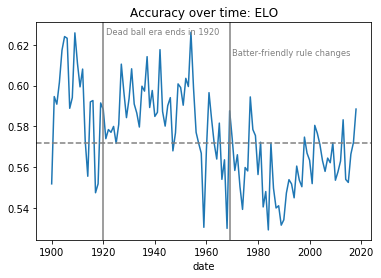

In [10]:
df.groupby(df.date.dt.year)['prediction_correct'].mean().plot()

plt.axhline(y=df['prediction_correct'].mean(), color='grey', linestyle="--")
plt.axvline(x=1920, color='grey')
plt.text(1921,0.625,'Dead ball era ends in 1920', color='grey', size='smaller')
plt.axvline(x=1969, color='grey')
plt.text(1970,0.615, 'Batter-friendly rule changes', color='grey', size='smaller')
plt.title("Accuracy over time: ELO");

It appears as if FiveThirtyEight's ELO model is relatively better at predicting the outcomes of games that occurred before 1958. For what reason this could be, I'm uncertain. I suppose it could have something to do with the expansions of the leagues, to 10 teams (in 1961 & 1962), then to 12, 14, and even 16 for the National League for some time. 

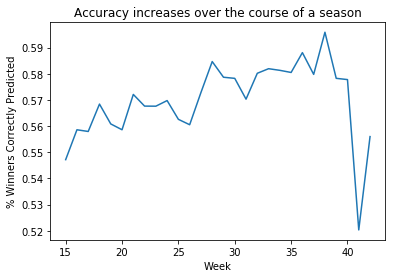

In [11]:
subset = df[(df.date.dt.week > 14) & (df.date.dt.week < 43)]
subset.groupby(df.date.dt.week)['prediction_correct'].mean().plot()
plt.title("Accuracy increases over the course of a season");
plt.xlabel('Week');
plt.ylabel('% Winners Correctly Predicted');

In [12]:
series = []
teams_by_gms = df.groupby('predicted_winner')['date'].count().sort_values(ascending=False)
series.append(teams_by_gms)
teams_by_gms.head()

predicted_winner
NYY    13566
SFG    11628
LAD    11391
STL    10991
BOS    10747
Name: date, dtype: int64

In [13]:
teams_by_win_predict = df.groupby('predicted_winner')['prediction_correct'].mean().sort_values(ascending=False)
series.append(teams_by_win_predict)

In [14]:
teams_by_loss_predict = df.groupby('predicted_loser')['prediction_correct'].mean().sort_values(ascending=False)
series.append(teams_by_loss_predict)

In [15]:
teams_by_home_win_predict = df.groupby('team1')['rating_prob1'].mean().sort_values(ascending=False)
series.append(teams_by_home_win_predict)

In [16]:
teams_by_away_win_predict = df.groupby('team2')['rating_prob2'].mean().sort_values(ascending=False)
series.append(teams_by_away_win_predict)

In [17]:
teams_by_loss_expect = df.groupby('loser')['loser_pct'].mean().sort_values(ascending=False)
series.append(teams_by_loss_expect)

In [18]:
teams_by_win_expect = df.groupby('winner')['winner_pct'].mean().sort_values(ascending=False)
series.append(teams_by_win_expect)

In [19]:
teams_df = pd.concat(series, axis=1)
teams_df.columns = ['Games played', 'Win pred correct %', 'Loss pred correct %', 'Likelihood as home', \
                   'Likelihood as road', 'Likelihood as loser', 'Likelihood as winner']

C:\Users\dariu\Miniconda3\envs\3point6\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [20]:
teams_df.sort_values('Games played', ascending=False)

,Games played,Win pred correct %,Loss pred correct %,Likelihood as home,Likelihood as road,Likelihood as loser,Likelihood as winner
NYY,13566,0.610718,0.544087,0.582969,0.513776,0.531444,0.561160
SFG,11628,0.584881,0.549825,0.560828,0.491412,0.512218,0.538235
LAD,11391,0.579141,0.557139,0.553837,0.483731,0.504732,0.531500
STL,10991,0.577927,0.558636,0.550695,0.481145,0.500861,0.529960
BOS,10747,0.580534,0.565350,0.548685,0.479160,0.496876,0.529760
PIT,9793,0.579087,0.568810,0.541738,0.472498,0.491045,0.522776
DET,9788,0.569166,0.563913,0.539503,0.470030,0.490829,0.518391
CLE,9770,0.576049,0.560465,0.543337,0.473940,0.493925,0.522790
CHW,9706,0.560478,0.562294,0.538020,0.468672,0.489614,0.516957
CHC,9352,0.571215,0.562753,0.538037,0.469149,0.489385,0.517875


In [46]:
teams_df['WWRank'] = teams_df['Win pred correct %'].rank(method='max', ascending=False)
teams_df['LLRank'] = teams_df['Loss pred correct %'].rank(ascending=True)
teams_df['HRank'] = teams_df['Likelihood as home'].rank(ascending=False)
teams_df['RRank'] = teams_df['Likelihood as road'].rank(ascending=False)
teams_df['LRank'] = teams_df['Likelihood as loser'].rank(ascending=False)
teams_df['WRank'] = teams_df['Likelihood as winner'].rank(ascending=False)
teams_df['GRank'] = teams_df['Games played'].rank(ascending=False)
teams_df

,level_0,index,Games played,Win pred correct %,Loss pred correct %,Likelihood as home,Likelihood as road,Likelihood as loser,Likelihood as winner,Team,WWRank,LLRank,HRank,RRank,LRank,WRank,GRank
0,0,ANA,4520,0.555088,0.551631,0.531540,0.462404,0.488300,0.505842,0,22.0,3.0,14.0,14.0,12.0,16.0,17.0
1,1,ARI,1576,0.564086,0.567524,0.527392,0.456637,0.479756,0.504677,1,17.0,13.0,15.0,15.0,15.0,17.0,28.0
2,2,ATL,8779,0.567832,0.586300,0.525438,0.455164,0.473717,0.507434,2,12.0,27.0,17.0,18.0,20.0,15.0,12.0
3,3,BAL,7936,0.567540,0.593626,0.516136,0.447357,0.464784,0.500359,3,13.0,28.0,24.0,24.0,27.0,20.0,14.0
4,4,BOS,10747,0.580534,0.565350,0.548685,0.479160,0.496876,0.529760,4,4.0,12.0,5.0,5.0,5.0,5.0,5.0
5,5,CHC,9352,0.571215,0.562753,0.538037,0.469149,0.489385,0.517875,5,9.0,10.0,9.0,9.0,10.0,9.0,10.0
6,6,CHW,9706,0.560478,0.562294,0.538020,0.468672,0.489614,0.516957,6,18.0,9.0,10.0,10.0,9.0,10.0,9.0
7,7,CIN,9255,0.570394,0.570250,0.533896,0.464625,0.485187,0.513553,7,10.0,17.0,12.0,12.0,13.0,11.0,11.0
8,8,CLE,9770,0.576049,0.560465,0.543337,0.473940,0.493925,0.522790,8,8.0,6.0,6.0,6.0,6.0,6.0,8.0
9,9,COL,1616,0.548267,0.575615,0.514512,0.442911,0.468887,0.489560,9,24.0,22.0,25.0,26.0,23.0,27.0,27.0


In [47]:
import plotly.plotly as py
import plotly.graph_objs as go

In [48]:
teams_df.style.background_gradient(cmap='summer')


,level_0,index,Games played,Win pred correct %,Loss pred correct %,Likelihood as home,Likelihood as road,Likelihood as loser,Likelihood as winner,Team,WWRank,LLRank,HRank,RRank,LRank,WRank,GRank
0,0,ANA,4520,0.555088,0.551631,0.53154,0.462404,0.4883,0.505842,0,22,3,14,14,12,16,17
1,1,ARI,1576,0.564086,0.567524,0.527392,0.456637,0.479756,0.504677,1,17,13,15,15,15,17,28
2,2,ATL,8779,0.567832,0.5863,0.525438,0.455164,0.473717,0.507434,2,12,27,17,18,20,15,12
3,3,BAL,7936,0.56754,0.593626,0.516136,0.447357,0.464784,0.500359,3,13,28,24,24,27,20,14
4,4,BOS,10747,0.580534,0.56535,0.548685,0.47916,0.496876,0.52976,4,4,12,5,5,5,5,5
5,5,CHC,9352,0.571215,0.562753,0.538037,0.469149,0.489385,0.517875,5,9,10,9,9,10,9,10
6,6,CHW,9706,0.560478,0.562294,0.53802,0.468672,0.489614,0.516957,6,18,9,10,10,9,10,9
7,7,CIN,9255,0.570394,0.57025,0.533896,0.464625,0.485187,0.513553,7,10,17,12,12,13,11,11
8,8,CLE,9770,0.576049,0.560465,0.543337,0.47394,0.493925,0.52279,8,8,6,6,6,6,6,8
9,9,COL,1616,0.548267,0.575615,0.514512,0.442911,0.468887,0.48956,9,24,22,25,26,23,27,27


In [49]:
teams_df.columns

Index(['level_0', 'index', 'Games played', 'Win pred correct %',
       'Loss pred correct %', 'Likelihood as home', 'Likelihood as road',
       'Likelihood as loser', 'Likelihood as winner', 'Team', 'WWRank',
       'LLRank', 'HRank', 'RRank', 'LRank', 'WRank', 'GRank'],
      dtype='object')

### A Heatmap of Team Ranks

In [55]:
ranks = teams_df[['index','GRank', 'WWRank',
       'LLRank', 'LRank', 'WRank', 'HRank', 'RRank']].sort_values('GRank')
ranks.set_index('index', inplace=True)
ranks.style.background_gradient(cmap='coolwarm')


,GRank,WWRank,LLRank,LRank,WRank,HRank,RRank
index,,,,,,,
NYY,1,1,1,1,1,1,1
SFG,2,3,2,2,2,2,2
LAD,3,5,4,3,3,3,3
STL,4,7,5,4,4,4,4
BOS,5,4,12,5,5,5,5
PIT,6,6,16,7,7,7,7
DET,7,11,11,8,8,8,8
CLE,8,8,6,6,6,6,6
CHW,9,18,9,9,10,10,10


There are a couple things here worth reviewing-- 

- firstly, there is a clearly visible tendency for teams with more games played to have higher probability of winning according to ELO. LRank, WRank, HRank and RRank, which display a team's ranking with regards to average probability of winning (given by ELO) in a loss, in a win, in a home game, and in a road game, respectively, follow this trend. The outliers: Anaheim, Houston, and Arizona (better avg. ELO win % than the trend); Oakland, Baltimore, Minnesota and Philadelphia (worse avg. ELO win % than the trend).

- the most variability in a field comes from LLRank-- the probability of a team winning when ELO predicts the team will lose. So, teams that lose 100% when ELO predicts them to lose will have a rank of 30 and a value of 0%. The average here is about 47%.

- ELO seems to do the best job at predicting the Oakland Athletics' outcomes, relative to all other teams-- they rank 2nd in win % when predicted to win by ELO, and 30th (last) in win % when predicted to lose. 

- Conversely, there are some teams that perform better when they're the ELO underdogs. The Angels, which rank an unremarkable 22nd in win % when expected to win, rank 3rd in win % when expected to lose. 